# Flood Detection using Deep Learning (Finetuning MobileNet, KERAS)

In [ ]:
# Loading required libraries and functions
import os
import shutil
import random
import itertools
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from keras import backend
from tensorflow import 

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Activation
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import decode_predictions, preprocess_input

In [19]:
# Loading data and preprocessing images according to mobilenet requirements
# Creating batches of data

labels = ['Flooding', 'No Flooding']
train_path = 'data/train'
valid_path = 'data/valid'
test_path = 'data/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 321 images belonging to 2 classes.


Found 81 images belonging to 2 classes.
Found 71 images belonging to 2 classes.


In [27]:
#Loading pre-trained lightweight mobilenet image classifier
mobile = tf.keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False)
# mobile.summary()

C:\Users\Glanil\AppData\Local\Temp\ipykernel_17776\2549745448.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobile = tf.keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False)


In [34]:
# Store all layers of the original mobilenet except the last 5 layers in variable x
# There is no predefined logic behind this, it just gives the optimal results for this task
# Also, we will be only training the last 12 layers of the mobilenet during finetuning as we want 
# it to keep all of the previously learned weights 
x = mobile.layers[-12].output
x

<KerasTensor shape=(None, None, None, 512), dtype=float32, sparse=False, ragged=False, name=keras_tensor_252>

In [46]:
# Create global pooling, dropout and a binary output layer, as we want our model to be a binary classifier, 
# i.e. to classify flooding and no flooding
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
output = Dense(units=2, activation='sigmoid')(x)

In [51]:
# Construct the new fine-tuned mode
model = Model(inputs=mobile.input, outputs=output)

In [55]:
# Freez weights of all the layers except for the last five layers in our new model, 
# meaning that only the last 12 layers of the model will be trained.
for layer in model.layers[:-23]:
    layer.trainable = False

In [58]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, None, None, 32) │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, None, None, 32) │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, None, None, 32) │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, None, None, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, None, None, 64) │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, None, None, 64) │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, None, None,     │         8,192 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, None, None,     │         1,152 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,633,474 (6.23 MB)

 Trainable params: 544,258 (2.08 MB)

 Non-trainable params: 1,089,216 (4.16 MB)

In [60]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [61]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=10,
          verbose=2
)

c:\Users\Glanil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


c:\Users\Glanil\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


33/33 - 16s - 474ms/step - accuracy: 0.4891 - loss: 3.6475 - val_accuracy: 0.8025 - val_loss: 0.4015
Epoch 2/10
33/33 - 5s - 165ms/step - accuracy: 0.6355 - loss: 2.5389 - val_accuracy: 0.9136 - val_loss: 0.2244
Epoch 3/10
33/33 - 5s - 156ms/step - accuracy: 0.6449 - loss: 2.3331 - val_accuracy: 0.9136 - val_loss: 0.1978
Epoch 4/10
33/33 - 5s - 150ms/step - accuracy: 0.7414 - loss: 1.5393 - val_accuracy: 0.9259 - val_loss: 0.1803
Epoch 5/10
33/33 - 5s - 154ms/step - accuracy: 0.7819 - loss: 1.4992 - val_accuracy: 0.9136 - val_loss: 0.2185
Epoch 6/10
33/33 - 5s - 159ms/step - accuracy: 0.8162 - loss: 1.1905 - val_accuracy: 0.9012 - val_loss: 0.3051
Epoch 7/10
33/33 - 5s - 148ms/step - accuracy: 0.8318 - loss: 1.2028 - val_accuracy: 0.9012 - val_loss: 0.2895
Epoch 8/10
33/33 - 5s - 154ms/step - accuracy: 0.8318 - loss: 1.0779 - val_accuracy: 0.9136 - val_loss: 0.2990
Epoch 9/10
33/33 - 5s - 155ms/step - accuracy: 0.8505 - loss: 1.0540 - val_accuracy: 0.9136 - val_loss: 0.3516
Epoch 10/10

In [63]:
# Saving and loading our trained for future use

model.save("fine_tuned_flood_detection_model.keras")
# model.load_weights('fine_tuned_flood_detection_model')

## Evaluate our finetuned model

In [72]:
# Prepare image for mobilenet prediction

def preprocess_image(file):
    img_path = 'evaluate/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

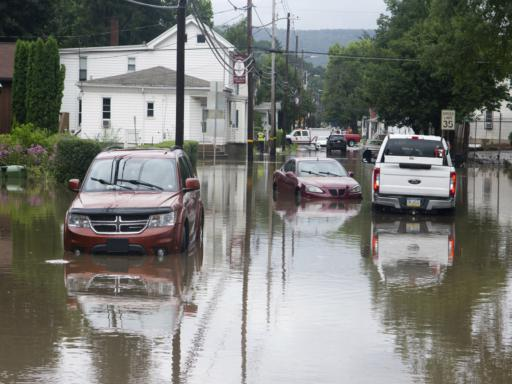

In [79]:
# Display image which we want to predict
from IPython.display import Image
Image(filename='evaluate/1.jpg', width=300,height=200) 

In [85]:
# Preprocess image and make prediction

preprocessed_image = preprocess_image('1.jpg')
predictions = model.predict(preprocessed_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [86]:
# Print predicted accuracy scores for both classes, i.e. (1) Flooding, (2) No Flooding
predictions

array([[9.407728e-01, 5.608436e-06]], dtype=float32)

In [87]:
# Get the maximum probability score for predicted class from predictions array
result = np.argmax(predictions)

In [88]:
# Print the predicted class label
labels[result]

'Flooding'

In [89]:
train_batches[0][1][1]

array([0., 1.], dtype=float32)